In [1]:
import sys, os, time
import shutil
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data

np.set_printoptions(linewidth=120, suppress=True)

In [3]:
media_root = '/is/ei/fleeb/workspace/media/hybrid/new/3dshapes'
# util.create_dir(media_root)
root = os.environ['FOUNDATION_SAVE_DIR']
root = '/is/ei/fleeb/workspace/trained_nets/managed'
names = [n for n in os.listdir(root) if not 'test' in n]
names = [n for n in names if 'zceleba' in n]
for i, name in enumerate(names):
    print(i,name)

0 107__zceleba__dvae__disc_steps=1
1 108__zceleba__dwae__disc_steps=1
2 109__zceleba__fdvae__disc_steps=1
3 110__zceleba__fdvae__disc_steps=1__prob=0p5
4 111__zceleba__fdwae__disc_steps=1
5 112__zceleba__fdwae__disc_steps=1__prob=0p5
6 113__zceleba__fvae__disc_steps=1
7 114__zceleba__fwae__disc_steps=1
8 115__zceleba__vae__disc_steps=1
9 116__zceleba__wae__disc_steps=1
10 117__zceleba__wgan__disc_steps=1
11 118__zceleba__wgan__default
12 119__zceleba__wpp__disc_steps=1


In [4]:
idx = 7

name = None

# idx = None
# name = '3dshapes-fdwae_0082-5923472-12_191218-100112'

if name is not None or idx is not None:
    if idx is not None: # load existing model args
        name = names[idx]
    path = os.path.join(root, name)
    cpath = train.find_checkpoint(path, load_last=True)
    A = None
    print('Using: {}'.format(name))
else: # create new model args
    path = None
    A = train.get_config('pycharm')
    print('Using: blank')

Using: 114__zceleba__fwae__disc_steps=1


In [29]:
A, (dataset, *other), model, ckpt = train.load(path=cpath, A=A, get_model=get_model, get_data=get_data, 
                                               return_args=True, return_ckpt=True)
print(model)
print(model.optim)
print(model.scheduler)

/is/ei/fleeb/workspace/foundation/foundation/train/config.py:58: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


Loaded /is/ei/fleeb/workspace/trained_nets/managed/114__zceleba__fwae__disc_steps=1/checkpoint_100.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
Dataset din=(3, 128, 128), dout=(3, 128, 128)
Model-type: fwpp
latent_disc: None (by default)
reg_prior: 0.5
ldisc_steps: 1 (by default)
ldisc_gp: 10.0 (by default)
encoder (type=double-enc): 
  in_shape --> din: (3, 128, 128) (by parent)
  channels: [64, 64, 128, 128, 128, 256] (by parent)
  factors: 2 (by parent)
  internal_channels: [None, None, None, None, None, None] (by default)
  squeeze: [False, False, False, False, False, False] (by default)
  residual: False (by default)
  nonlin: elu (by parent)
  output_nonlin: None (by default)
  output_norm_type: None (by default)
  down_type: max (by parent)
  norm_type: instance (by parent)
  latent_dim: 32 (by parent)
  tail (type=mlp): 
    input_dim --> din: (256, 2, 2)
    output_dim --> dout: 32
    hidden_dims: [256, 128]
    nonlin: elu (by parent)
    output_nonlin: None (b

ValueError: too many values to unpack (expected 2)

In [30]:
records = ckpt['records']
print('Trained on {:2.2f} M samples'.format(records['total_samples']['train']/1e6))
if len(other):
    dataset = other[0]
    print('Using validation set')
else:
    print('Using training set')

Trained on 14.65 M samples
Using validation set


In [54]:
A.dataset.batch_size = 9
common_Ws = {64:8, 32:4, 16:4, 9:3, 8:2, 4:2}
img_W = common_Ws[A.dataset.batch_size]
loader = train.get_loaders(dataset, batch_size=A.dataset.batch_size, num_workers=A.num_workers,
                            shuffle=True, drop_last=False, )
util.set_seed(0)
loader = iter(loader)

In [55]:
batch = next(loader)
batch = next(loader)
batch = util.to(batch, A.device)

In [56]:
save_dir = os.path.join(media_root, name)
reverse_rows = False
grdlines = False
save_figs = True
save_model = True
if save_figs:
    util.create_dir(save_dir)
    if save_model:
        util.create_dir(os.path.join(save_dir, 'model'))
        fnames = [os.path.basename(cpath), 'config.yml']
        for fnm in fnames:
            if fnm in os.listdir(path):
                shutil.copyfile(os.path.join(path, fnm), os.path.join(save_dir, fnm))
                print('Copied {}'.format(fnm))

Copied checkpoint_100.pth.tar
Copied config.yml


In [57]:
def show_nums(imgs, titles=None, H=None, W=None, figsize=(6,6)):
    if H is None and W is None:
        B = imgs.size(0)
        l = int(np.sqrt(B))
        assert l**2 == B, 'not right: {} {}'.format(l, B)
        H, W = l, l
    elif H is None:
        H = imgs.shape[0] // W
    elif W is None:
        W = imgs.shape[0] // H
    
    imgs = imgs.cpu().permute(0,2,3,1).squeeze().numpy()
    
    fig, axes = plt.subplots(H, W, figsize=figsize)
    
    if titles is None:
        titles = [None]*len(imgs)
    
    iH, iW = imgs.shape[1], imgs.shape[2]
    
    for ax, img, title in zip(axes.flat, imgs, titles):
        plt.sca(ax)
        if reverse_rows:
            img = img[::-1]
        plt.imshow(img)
        if grdlines:
            plt.plot([0,iW],[iH/2,iH/2],c='r',lw=.5,ls='--')
            plt.plot([iW/2,iW/2],[0,iH],c='r',lw=.5,ls='--')
            plt.xlim(0,iW)
            plt.ylim(0,iH)
        if title is not None:
            plt.xticks([])
            plt.yticks([])
            plt.title(title)
        else:
            plt.axis('off')
#     fig.tight_layout()
    return fig

In [58]:
# # args.dataset = '3dshapes'
# args.dataset = 'dsprites'

# datasets = get_data(args)

In [59]:
plt.close('all')

In [60]:
X, = batch
X.shape#, Y.shape

torch.Size([9, 3, 128, 128])

<IPython.core.display.Javascript object>


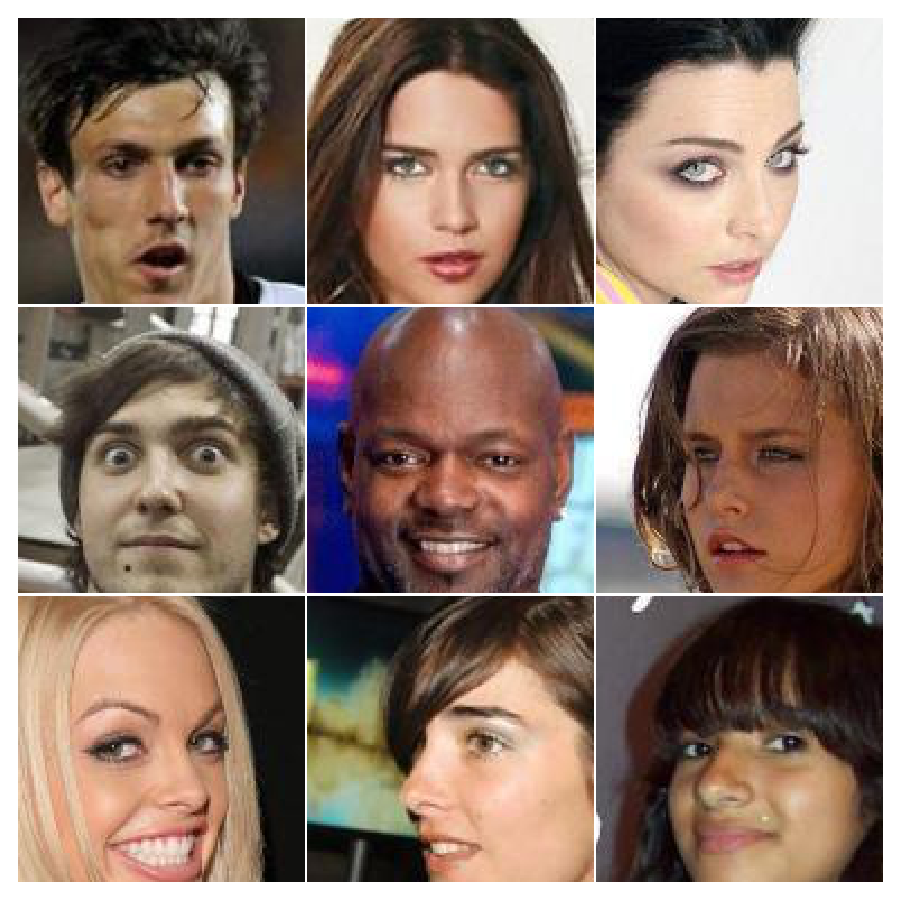

In [61]:
fig = show_nums(X, figsize=(9,9), H=img_W)
# fig.suptitle("originals", fontsize=14)
# plt.tight_layout()
border, between = 0.02, 0.01
plt.subplots_adjust(wspace=between, hspace=between, 
                    left=border, right=1-border, bottom=border, top=1-border)
if save_figs:
    plt.savefig(os.path.join(save_dir,'originals.png'))

<IPython.core.display.Javascript object>


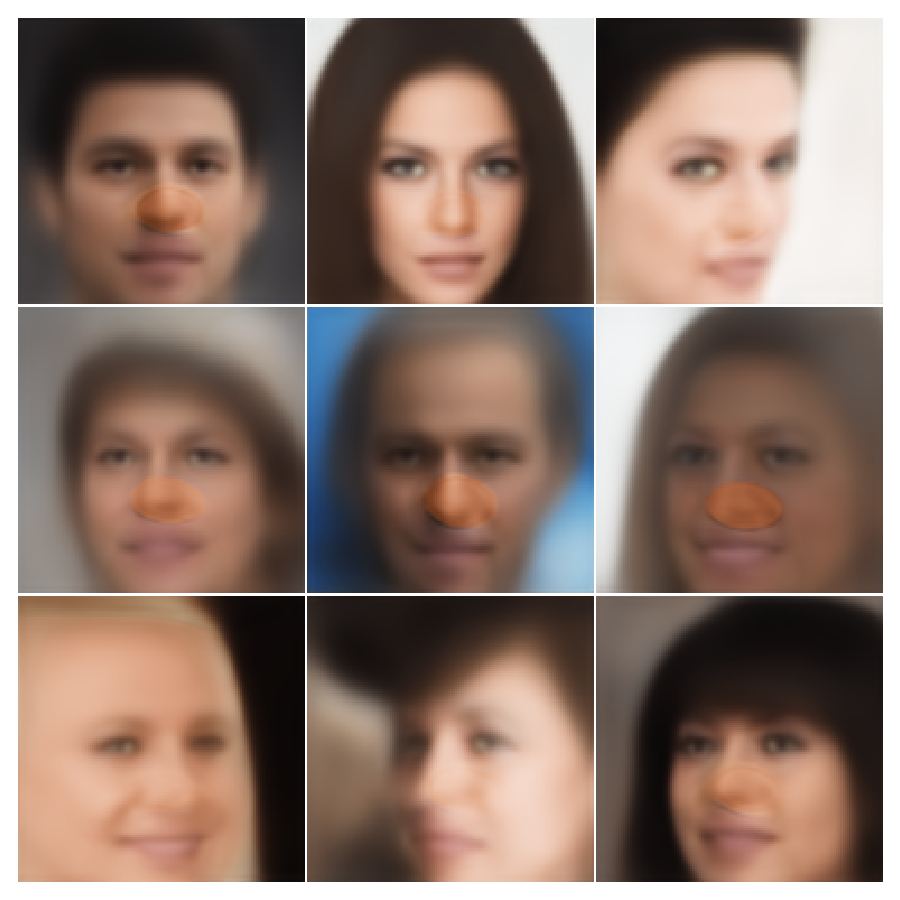

In [62]:
with torch.no_grad():
    
    if model.enc is None:
        q = model.sample_prior(X.size(0))
    else:
        q = model.encode(X)
    qdis = q
    qmle = q
    if isinstance(q, distrib.Distribution):
        q = q.rsample()
        qmle = qdis.loc
    rec = model.decode(q)
    vrec = model.disc(rec) if model.disc is not None else None
fig = show_nums(rec,figsize=(9,9),  W=img_W)#['{:4.0f}'.format(v.item()) for v in vrec])
# fig.suptitle("reconstructions" if model.enc is not None else 'generated', fontsize=14)
plt.subplots_adjust(wspace=between, hspace=between, 
                    left=border, right=1-border, bottom=border, top=1-border)
rec.shape#, q.shape
if save_figs:
    plt.savefig(os.path.join(save_dir,'recs.png' if model.enc is not None else 'gen.png'))

In [44]:
stats = qmle.min(0)[0], qmle.max(0)[0], qmle.mean(0), qmle.std(0)
stat_names = ['min', 'max', 'mean', 'std']
stats

(tensor([ -0.2389,  -0.8232,  -0.3586,  -0.1631,  -0.2802,  -5.9405,  -4.2616,
          -1.0679,  -0.2378,  -0.4513,  -0.2094,  -0.5565,  -0.1263,  -6.9321,
          -4.0510,  -6.7825,  -9.5082,  -0.1496,  -0.2550,  -0.1205,  -7.7503,
          -4.7349,  -0.5709,  -0.1503,  -6.0923,  -0.4650,  -0.1653,  -0.3560,
          -5.7950,  -3.3574, -10.1668,  -0.6014], device='cuda:0'),
 tensor([0.5042, 0.3020, 0.2516, 0.4348, 0.4310, 6.3782, 4.7489, 0.2730, 0.8810,
         0.3241, 0.4973, 0.2878, 0.3276, 5.6675, 6.7858, 7.0901, 3.9085, 0.7160,
         0.5282, 0.2394, 8.8681, 6.2364, 0.1933, 0.3363, 4.1112, 0.1882, 0.1322,
         0.1318, 5.0866, 3.7876, 5.7837, 0.3534], device='cuda:0'),
 tensor([-0.0096, -0.0006,  0.0199,  0.0143,  0.0184,  0.5091,  0.5438, -0.0086,
          0.0199,  0.0040,  0.0217,  0.0023,  0.0061,  0.2120,  0.1318,  0.4829,
         -0.3880,  0.0352,  0.0078,  0.0161, -0.0456,  0.4150, -0.0118,  0.0186,
         -0.1854, -0.0130, -0.0122, -0.0110, -0.1085,  0.1253,

<IPython.core.display.Javascript object>


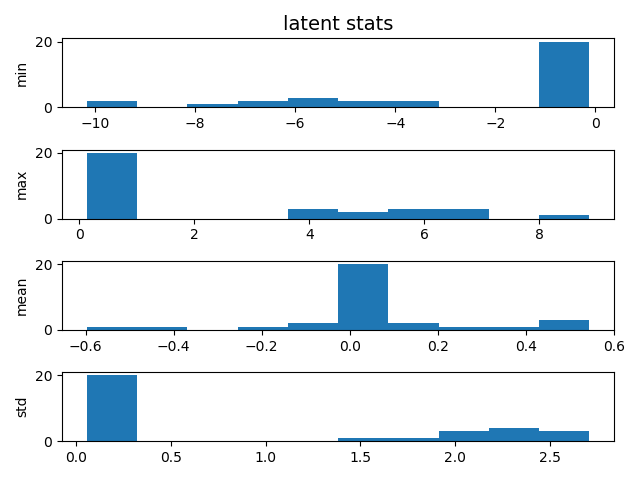

In [45]:
fig, axs = plt.subplots(4)
plt.sca(axs[0])
plt.title("latent stats", fontsize=14)
for ax, stat, sname in zip(axs, stats, stat_names):
    plt.sca(ax)
    plt.ylabel(sname)
    plt.hist(stat.cpu().numpy())
plt.tight_layout()
if save_figs:
    plt.savefig(os.path.join(save_dir,'stats.png'))
pass

In [46]:
# if isinstance(qdis, distrib.Distribution):
#     mu, sigma = qdis.loc, qdis.scale
#     stats = sigma.min(0)[0], sigma.max(0)[0], sigma.mean(0), sigma.std(0)
    
#     fig, axs = plt.subplots(4)
#     for ax, stat, sname in zip(axs, stats, stat_names):
#         plt.sca(ax)
#         plt.ylabel(sname)
#         plt.hist(stat.cpu().numpy())
#     fig.suptitle("scales", fontsize=14)
#     plt.tight_layout()

<IPython.core.display.Javascript object>


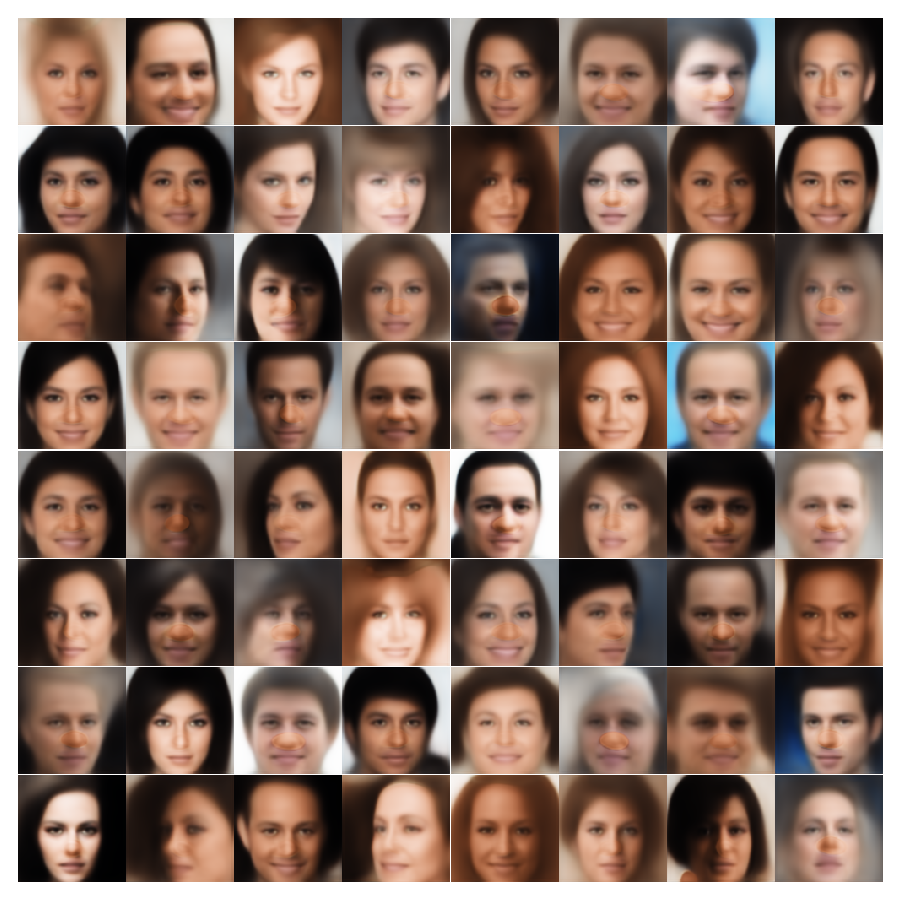

(torch.Size([64, 32]), torch.Size([64, 3, 128, 128]))

In [47]:
with torch.no_grad():
    mix = util.shuffle_dim(q)
#     try:
#         hyb = model.hybridize(qdis)
#     except NotImplementedError:
#         model.splits = model.latent_dim
#         hyb = Hybrid_Generator.hybridize(model, qdis)
    hygen = model.decode(mix)
    vhyb = model.disc(hygen) if model.disc is not None else None
fig = show_nums(hygen,figsize=(9,9),W=img_W)#, ['{:4.0f}'.format(v.item()) for v in vhyb])
# fig.suptitle("hybrid", fontsize=14)
plt.subplots_adjust(wspace=between, hspace=between, 
                    left=border, right=1-border, bottom=border, top=1-border)
if save_figs:
    plt.savefig(os.path.join(save_dir,'hybrids.png'))
mix.shape, hygen.shape

<IPython.core.display.Javascript object>


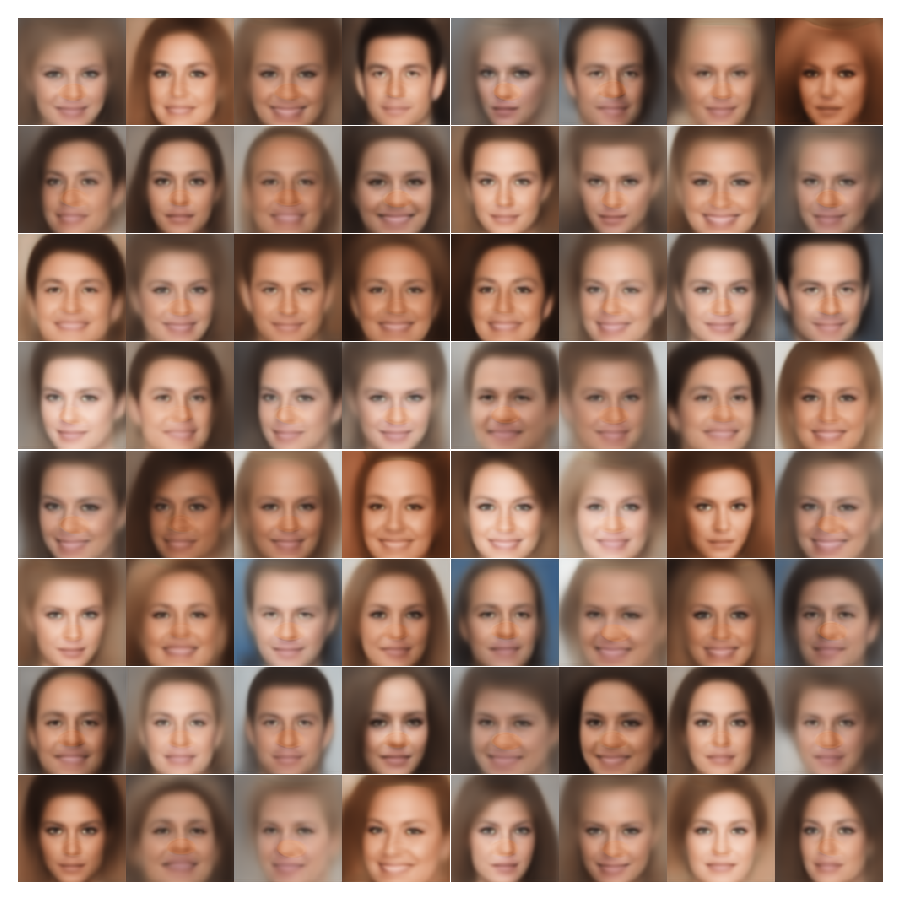

In [48]:
with torch.no_grad():
    gen = model.generate(X.size(0))
fig = show_nums(gen,figsize=(9,9), W=img_W )#['{:4.0f}'.format(v.item()) for v in vrec])
# fig.suptitle("generated", fontsize=14)
plt.subplots_adjust(wspace=between, hspace=between, 
                    left=border, right=1-border, bottom=border, top=1-border)
if save_figs:
    plt.savefig(os.path.join(save_dir,'gen.png'))
pass

In [207]:
# plt.close('all')

In [208]:
# # dim = 3
# idx = 1

# plt.figure()
# plt.imshow(rec[idx,0].cpu().numpy())
# plt.axis('off')
# pass

In [211]:
q.shape

torch.Size([9, 32])

In [51]:

latent_dim = A.model.latent_dim
iH, iW = X.shape[-2:]

rows = 4
steps = 60
bounds = -2,2
# bounds = None
dlayout = rows, latent_dim//rows
outs = []

all_diffs = []
inds = [0, 2, 3]
inds = np.arange(len(q))
save_inds = [0, 1, 2, 3]
# save_inds =  []



for idx in inds:

    walks = []
    for dim in range(latent_dim):

        dev = q[:,dim].std()
        if bounds is None:
            deltas = torch.linspace(q[:,dim].min(), q[:,dim].max(), steps)
        else:
            deltas = torch.linspace(bounds[0],bounds[1], steps)
        vecs = torch.stack([q[idx]]*steps)
        vecs[:,dim] = deltas

        with torch.no_grad():
            walks.append(model.decode(vecs).cpu())

    walks = torch.stack(walks,1)
    chn = walks.shape[2]

    dsteps = 10
    diffs = (walks[dsteps:] - walks[:-dsteps]).abs()#.view(steps-dsteps, latent_dim, chn, 64*64)
#     diffs /= (walks[dsteps:]).abs()
    #diffs = diffs.clamp(min=1e-10,max=1).abs()
    diffs = diffs.view(steps-dsteps, latent_dim, chn* iH*iW).mean(-1)
#     diffs = 1 - diffs.mean(-1)
#     print(diffs.shape)
#     diffs *= 2
    all_diffs.append(diffs.mean(0))
#     print(all_diffs[-1])

    if save_figs and idx in save_inds:
        
        walks_full = walks.view(steps, dlayout[0], dlayout[1], chn, iH, iW).permute(0,1,4,2,5,3).contiguous().view(steps,iH*dlayout[0],iW*dlayout[1],chn).squeeze()
        images = []
        for img in walks_full.cpu().numpy():
            images.append((img*255).astype(np.uint8))
        imageio.mimsave(os.path.join(save_dir, 'walks-idx{}.gif'.format(idx,dim)), images)

        with open(os.path.join(save_dir, 'walks-idx{}.gif'.format(idx,dim)),'rb') as f:
            outs.append(display.Image(data=f.read(), format='gif'))
        del walks_full
all_diffs = torch.stack(all_diffs)
# outs[0] if len(outs) else None

NameError: name 'out' is not defined

In [74]:
# outs[1]

In [214]:
# outs[2]

IndexError: list index out of range

In [215]:
# outs[3]

IndexError: list index out of range

<IPython.core.display.Javascript object>


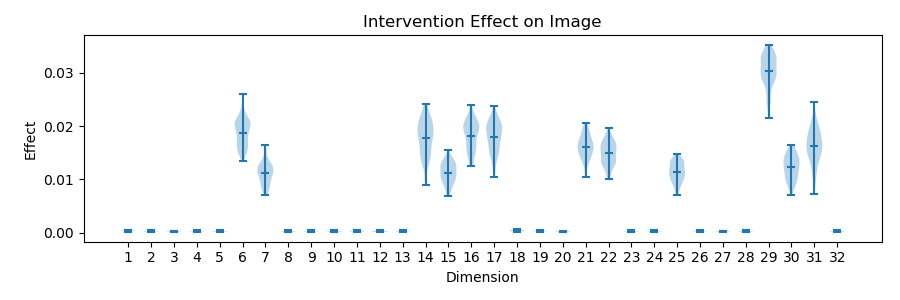

In [52]:
# violin plot of image effects
vals = all_diffs.cpu().numpy()
Xl = np.arange(vals.shape[-1])
fig, ax = plt.subplots(figsize=(9,3))
plt.violinplot(vals, Xl, points=200, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)
plt.xticks(Xl, map(str, Xl+1))
plt.title('Intervention Effect on Image')
plt.xlabel('Dimension')
plt.ylabel('Effect')
plt.tight_layout()
if save_figs:
    plt.savefig(os.path.join(save_dir,'effect.png'))
pass